Took a subset of the dataset(10% of the whole dataset free to do this on whole dataset, given the memory requirements)

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit

In [2]:
df1=pd.read_csv(r"C:\Users\dheer\Documents\DSP ipynb\earthquake\train_values.csv")
df2=pd.read_csv(r"C:\Users\dheer\Documents\DSP ipynb\earthquake\train_labels.csv")

In [ ]:
df2.head

In [3]:
len(df1)==len(df2)

True

In [4]:
df1.insert(len(df1.columns),'damage_grade',df2["damage_grade"])

In [5]:
df1.shape

(260601, 40)

In [6]:
# Taking a sample of 10% of the total data set. 
df = df1.sample(frac=0.1, random_state=42)
df.head(3)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
111801,1023112,10,1224,11128,1,20,7,3,t,r,...,0,0,0,0,0,0,0,0,0,2
91817,64407,22,1101,12483,2,60,7,6,t,r,...,0,0,0,0,0,0,0,0,0,2
251661,967834,26,39,11440,2,50,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2


[Text(0.5, 1.0, 'Distribution of damage_grade')]

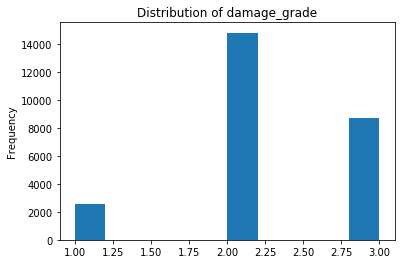

In [7]:
df["damage_grade"].plot.hist().set(title='Distribution of damage_grade')

## 1. Feature selection

droping columns legal_ownership_status, count_families, has_secondary_use and all other secondary_use features because they don't contribute much to the damage of building.

[Text(0.5, 1.0, 'Distribution of damage_grade when building has secondary use')]

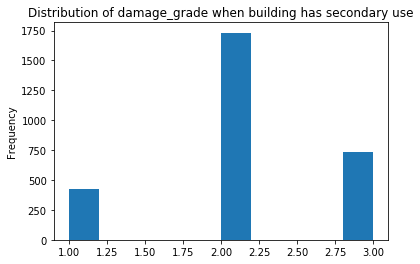

In [8]:
df.loc[df["has_secondary_use"]==1,"damage_grade"].plot.hist().set(title='Distribution of damage_grade when building has secondary use')

In [9]:
df.drop(['legal_ownership_status','count_families','has_secondary_use','has_secondary_use_agriculture','has_secondary_use_hotel','has_secondary_use_rental','has_secondary_use_institution','has_secondary_use_school','has_secondary_use_industry','has_secondary_use_health_post','has_secondary_use_gov_office','has_secondary_use_use_police','has_secondary_use_other'],axis=1,inplace=True)

dropping geo_level1_id and geo_level_2_id because geo_level_3_id already gives us more specific information about the location.

In [10]:
df.drop(['geo_level_1_id','geo_level_2_id'],axis=1,inplace=True)

In [11]:
df.drop(["building_id"],axis=1,inplace=True)

Text(0.5, 1, 'Correlation Matrix')

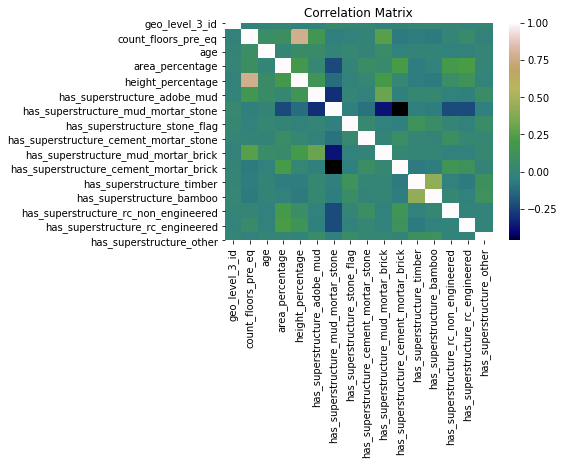

In [12]:
corr = df.iloc[:,df.columns!= "damage_grade"].corr()
sns.heatmap(corr,cmap="gist_earth").set_title("Correlation Matrix")

height_percentage and count_floors_pre_eq has high correlation. so dropping count_floors_pre_eq

In [13]:
df.drop(["count_floors_pre_eq"],axis=1,inplace=True)

In [14]:
df.shape

(26060, 23)

Changing non numeric as categorical variables.

In [15]:
cat_variables = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type','other_floor_type','position','plan_configuration','damage_grade']
for col in cat_variables:
    df[col] = df[col].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26060 entries, 111801 to 251597
Data columns (total 23 columns):
geo_level_3_id                            26060 non-null int64
age                                       26060 non-null int64
area_percentage                           26060 non-null int64
height_percentage                         26060 non-null int64
land_surface_condition                    26060 non-null category
foundation_type                           26060 non-null category
roof_type                                 26060 non-null category
ground_floor_type                         26060 non-null category
other_floor_type                          26060 non-null category
position                                  26060 non-null category
plan_configuration                        26060 non-null category
has_superstructure_adobe_mud              26060 non-null int64
has_superstructure_mud_mortar_stone       26060 non-null int64
has_superstructure_stone_flag             260

## 2.Preprocess the data 
### A.Convert percentage to value/100 

In [16]:
df['area_dec']=df["area_percentage"]/100
df.pop("area_percentage")

111801    7
91817     7
251661    6
205479    7
22618     8
         ..
139936    5
2436      6
192829    6
249763    7
251597    6
Name: area_percentage, Length: 26060, dtype: int64

In [17]:
df.shape

(26060, 23)

### B. 80-20 stratified split based on the target variable

In [18]:
X = df.drop(['damage_grade'],axis=1)
y = df[['damage_grade']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=42, stratify=y['damage_grade'])

### C. ratio of classes on each dataset

In [19]:
a=y['damage_grade'].value_counts()/len(y)
b=y_train['damage_grade'].value_counts()/len(y_train)
c=y_test['damage_grade'].value_counts()/len(y_test)
print("{0}\n{1}\n{2}".format(a,b,c))

2    0.567613
3    0.334689
1    0.097698
Name: damage_grade, dtype: float64
2    0.567584
3    0.334708
1    0.097707
Name: damage_grade, dtype: float64
2    0.567728
3    0.334612
1    0.097659
Name: damage_grade, dtype: float64


### D. Encode the categorical features

In [20]:
le = LabelEncoder()

X_train["land_surface_condition"] = le.fit_transform(X_train["land_surface_condition"])
X_test["land_surface_condition"]= le.transform(X_test["land_surface_condition"])

X_train["foundation_type"] = le.fit_transform(X_train["foundation_type"])
X_test["foundation_type"]= le.transform(X_test["foundation_type"])

X_train["roof_type"] = le.fit_transform(X_train["roof_type"])
X_test["roof_type"]= le.transform(X_test["roof_type"])

X_train["ground_floor_type"] = le.fit_transform(X_train["ground_floor_type"])
X_test["ground_floor_type"]= le.transform(X_test["ground_floor_type"])

X_train["other_floor_type"] = le.fit_transform(X_train["other_floor_type"])
X_test["other_floor_type"]= le.transform(X_test["other_floor_type"])

X_train["position"] = le.fit_transform(X_train["position"])
X_test["position"]= le.transform(X_test["position"])

X_train["plan_configuration"] = le.fit_transform(X_train["plan_configuration"])
X_test["plan_configuration"]= le.transform(X_test["plan_configuration"])


C:\Users\dheer\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\dheer\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\dheer\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

### E. Standardize the numerical features

In [21]:
num_fe = ['geo_level_3_id','height_percentage','age','area_dec']
scaler = StandardScaler()
X_train[num_fe] = scaler.fit_transform(X_train[num_fe])
X_test[num_fe] = scaler.fit_transform(X_test[num_fe])

C:\Users\dheer\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\dheer\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\dheer\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

## 3. Build a SVM Classifier, train the model

In [40]:
clf = SVC(kernel='rbf',cache_size=1000,C=1000,random_state = 42,gamma=0.01) 
clf.fit(X_train,y_train)

C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1000, cache_size=1000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [41]:
y_pred = clf.predict(X_test)

In [42]:
f1_score(y_test, y_pred, average='micro')

0.5844205679201842

In [77]:
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-4, 1, 6)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dheer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

The best parameters are {'C': 1000.0, 'gamma': 0.01} with a score of 0.58


### hyper-parameters that can be tuned in SVM Classifier:
* C: C is the regularization parameter in SVM. If C value is higher it will have narrow margins and builds a complex model, but chances are the model might overfit. With lower C values margins are wider and builds a simpler model.
* kernel: By choosing different kernel we can choose the cost function for model.
* gamma: The gamma parameter can be seen as the inverse of the radius of influence of samples selected by the model as support vectors. With low values meaning more influence and high values meaning less influence. 

I have used grid search to find the best parameters for SVC. With search values for C ranging from 0.01-1000 and gamma from 0.0001-10. The maximum F1 score I could get was 0.58 for 'C': 1000.0, 'gamma': 0.01. In my earlier run I got a score of 0.56 now its improved to 0.58

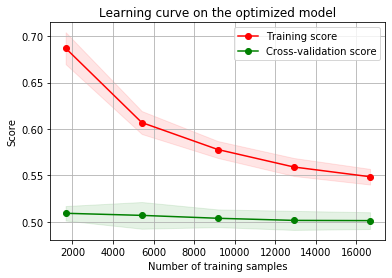

In [48]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.title(title)
    plt.xlabel("Number of training samples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,train_sizes=train_sizes,scoring='f1_weighted')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")


    return plt


title = r"Learning curve on the optimized model"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(clf, title, X_train, y_train, ylim=(0.5, 1.01),cv=cv, n_jobs=4)

plt.show()

Score deteriorates in training but remains constant during cross-validation as the sample size increases.

## 4. Decision Tree Classifier

In [30]:
classifier = DecisionTreeClassifier(random_state=42,max_depth=4)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [31]:
y_pred1 = classifier.predict(X_test)
f1_score(y_test, y_pred, average='micro')

0.5638910207214122

## 5. Model Comparision
* since it is a classification model I am considering F1 score as an accurate metrics to evaluate models. As this is a multilabel classification F1_micro or average F1 is calculated.
* SVC got an F1 score of 0.58 and decision tree got an F1 score of 0.56. In this case SVM classifier performed better than decision tree based on the F1 score.